In [1]:
!pip install -q -U transformers datasets accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fss

In [2]:
!pip install torch

In [3]:
import pandas as pd
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [4]:
df = pd.read_csv("/content/drive/MyDrive/MY NOTEBOOK/MODULO 6 - CNN,RNN,LSTM,TRANFOMER.../all-data.csv",encoding="ISO-8859-1")
header = ['label','content']
df.columns = header
df.head(10)


,label,content
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,positive,"For the last quarter of 2010 , Componenta 's n..."
6,positive,"In the third quarter of 2010 , net sales incre..."
7,positive,Operating profit rose to EUR 13.1 mn from EUR ...
8,positive,"Operating profit totalled EUR 21.1 mn , up fro..."
9,positive,TeliaSonera TLSN said the offer is in line wit...


In [5]:
classes = df['label'].unique()
classes = {class_name : idx for idx,class_name in enumerate(classes.tolist()) }
df['label']=df['label'].map(classes)
df.head(10)


,label,content
0,0,Technopolis plans to develop in stages an area...
1,1,The international electronic industry company ...
2,2,With the new production plant the company woul...
3,2,According to the company 's updated strategy f...
4,2,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,2,"For the last quarter of 2010 , Componenta 's n..."
6,2,"In the third quarter of 2010 , net sales incre..."
7,2,Operating profit rose to EUR 13.1 mn from EUR ...
8,2,"Operating profit totalled EUR 21.1 mn , up fro..."
9,2,TeliaSonera TLSN said the offer is in line wit...


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [19]:
import torch
from torch.utils.data import Dataset

class SetimentDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [20]:

def create_dataset(df, tokenizer, max_len):

    dataset = SetimentDataset(
        sentences=df['content'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return dataset


In [21]:
MAX_LEN = 160





model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)



train_dataset = create_dataset(df_train, tokenizer, MAX_LEN )

val_dataset =create_dataset(df_val, tokenizer, MAX_LEN )

test_dataset = create_dataset(df_test, tokenizer, MAX_LEN )

In [22]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

In [23]:
num_labels = 3
from transformers import AutoConfig
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="text-classification"
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoConfig


training_args = TrainingArguments(
    output_dir="save_model",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [25]:
trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.629275,0.741736
2,No log,0.527368,0.776860
3,No log,0.443789,0.822314
4,No log,0.456176,0.828512
5,No log,0.476854,0.834711
6,No log,0.487099,0.836777
7,No log,0.513725,0.832645
8,No log,0.523474,0.832645


TrainOutput(global_step=248, training_loss=0.30390379505772747, metrics={'train_runtime': 914.7976, 'train_samples_per_second': 33.896, 'train_steps_per_second': 0.271, 'total_flos': 2549569017784320.0, 'train_loss': 0.30390379505772747, 'epoch': 8.0})

**Sau khi train ,ta có vizualize :**

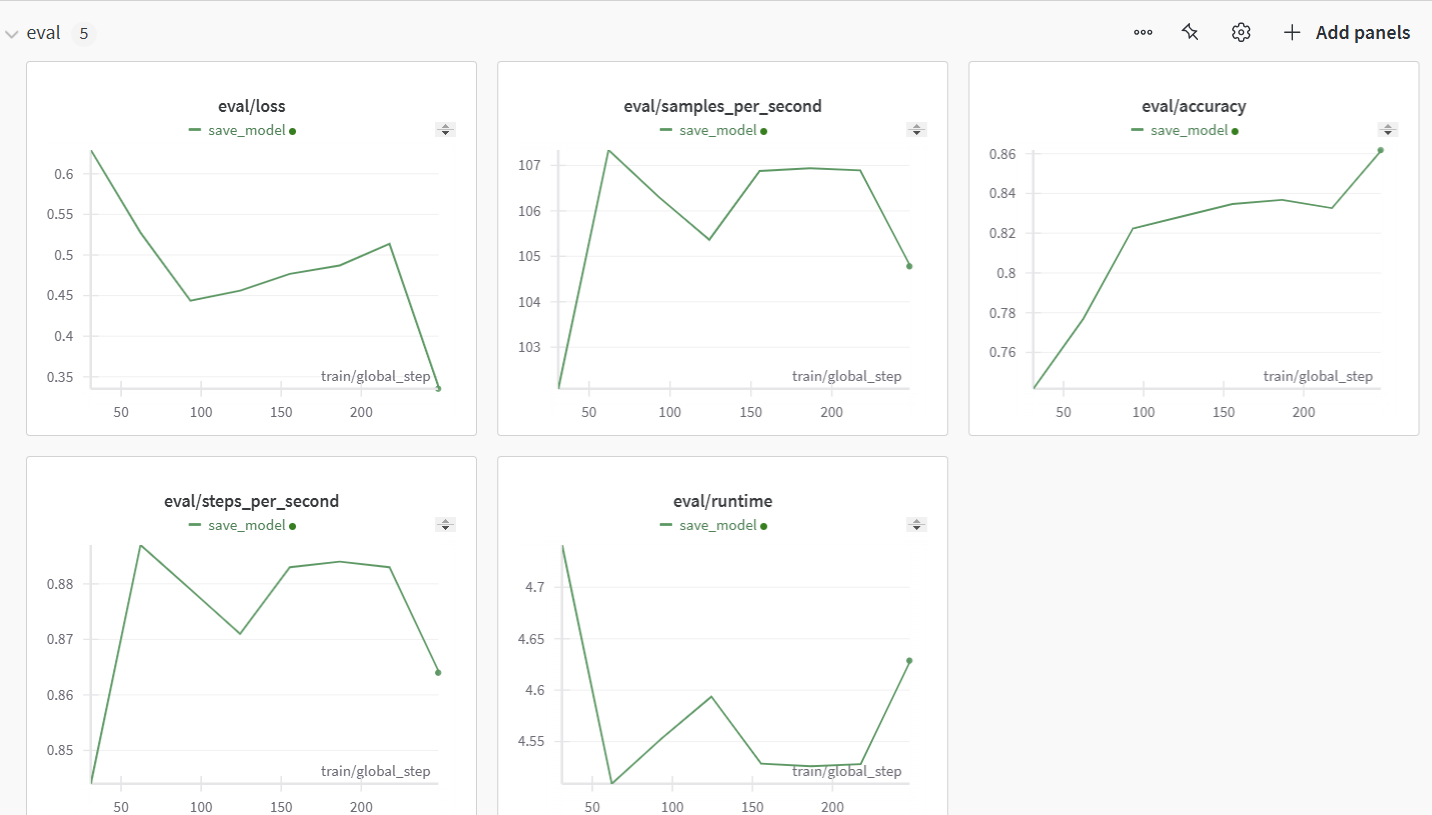

In [26]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.33530622720718384,
 'eval_accuracy': 0.8618556701030928,
 'eval_runtime': 4.6287,
 'eval_samples_per_second': 104.78,
 'eval_steps_per_second': 0.864,
 'epoch': 8.0}